## 数据分析
数据分析的价值主要在于熟悉了解整个数据集的基本情况包括每个文件里有哪些数据，具体的文件中的每个字段表示什么实际含义，以及数据集中特征之间的相关性，在推荐场景下主要就是分析用户本身的基本属性，文章基本属性，以及用户和文章交互的一些分布，这些都有利于后面的召回策略的选择，以及特征工程。

**建议：当特征工程和模型调参已经很难继续上分了，可以回来在重新从新的角度去分析这些数据，或许可以找到上分的灵感**

In [1]:
# 导入相关包
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

# jupyter notebook同时显示多个结果
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")
data_path = 'C:/Users/cross/Desktop/team-learning-data-mining-Datawhale/NewsRecommender/data_raw/'
save_path = 'C:/Users/cross/Desktop/team-learning-data-mining-Datawhale/NewsRecommender/tmp_results/'

### 数据表
* <tdtrain_click_log.csv：训练集用户点击日志


In [2]:
## 1）简略观察数据(head()+shape)
path = data_path
#####train
trn_click = pd.read_csv(path+'train_click_log.csv') # 训练集用户点击日志
item_df = pd.read_csv(path+'articles.csv') # 新闻文章信息数据表
item_emb_df = pd.read_csv(path+'articles_emb.csv') # 新闻文章embedding向量表示
#####test
tst_click = pd.read_csv(path+'testA_click_log.csv') # 测试集用户点击日志

trn_click.head().append(trn_click.tail())
trn_click.shape
item_df.head().append(item_df.tail())
item_df.shape
item_emb_df.head().append(item_emb_df.tail())
item_emb_df.shape
tst_click.head().append(tst_click.tail())
tst_click.shape

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,199999,160417,1507029570190,4,1,17,1,13,1
1,199999,5408,1507029571478,4,1,17,1,13,1
2,199999,50823,1507029601478,4,1,17,1,13,1
3,199998,157770,1507029532200,4,1,17,1,25,5
4,199998,96613,1507029671831,4,1,17,1,25,5
1112618,33446,16346,1508212054157,4,3,2,1,25,1
1112619,0,30760,1508211672520,4,1,17,1,25,2
1112620,0,157507,1508211702520,4,1,17,1,25,2
1112621,199178,234481,1508211513583,4,3,2,1,25,2
1112622,199178,233578,1508211543583,4,3,2,1,25,2


(1112623, 9)

,article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


(364047, 4)

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
364042,364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,...,-0.410550,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,364043,-0.136932,-0.995472,0.991298,0.031871,-0.915621,-0.658517,0.633090,-0.564356,0.676551,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726
364046,364046,-0.257134,-0.994631,0.983792,-0.190975,-0.953720,-0.893823,0.708974,-0.557027,0.846842,...,-0.490481,-0.689666,-0.661846,0.490945,0.736526,0.667668,0.902130,0.983873,-0.838183,-0.179283


(364047, 251)

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,249999,160974,1506959142820,4,1,17,1,13,2
1,249999,160417,1506959172820,4,1,17,1,13,2
2,249998,160974,1506959056066,4,1,12,1,13,2
3,249998,202557,1506959086066,4,1,12,1,13,2
4,249997,183665,1506959088613,4,1,17,1,15,5
518005,221924,70758,1508211323220,4,3,2,1,25,2
518006,207823,331116,1508211542618,4,3,2,1,25,1
518007,207823,234481,1508211850103,4,3,2,1,25,1
518008,207823,211442,1508212189949,4,3,2,1,25,1
518009,207823,211401,1508212315718,4,3,2,1,25,1


(518010, 9)

In [3]:
## 2) 数据总览(describe()来熟悉数据的相关统计量+info()来熟悉数据类型):
trn_click.describe()
trn_click.info()
item_df.describe()
item_df.info()
item_emb_df.describe()
item_emb_df.info()
tst_click.describe()
tst_click.info()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112623 entries, 0 to 1112622
Data columns (total 9 columns):
user_id                1112623 non-null int64
click_article_id       1112623 non-null int64
click_timestamp        1112623 non-null int64
click_environment      1112623 non-null int64
click_deviceGroup      1112623 non-null int64
click_os               1112623 non-null int64
click_country          1112623 non-null int64
click_region           1112623 non-null int64
click_referrer_type    1112623 non-null int64
dtypes: int64(9)
memory usage: 76.4 MB


,article_id,category_id,created_at_ts,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.000000
mean,182023.000000,283.108239,1.474070e+12,190.897727
std,105091.461061,136.723470,4.293038e+10,59.502766
min,0.000000,0.000000,1.159356e+12,0.000000
25%,91011.500000,199.000000,1.444925e+12,159.000000
50%,182023.000000,301.000000,1.489422e+12,186.000000
75%,273034.500000,399.000000,1.509891e+12,218.000000
max,364046.000000,460.000000,1.520943e+12,6690.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 4 columns):
article_id       364047 non-null int64
category_id      364047 non-null int64
created_at_ts    364047 non-null int64
words_count      364047 non-null int64
dtypes: int64(4)
memory usage: 11.1 MB


,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
count,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,...,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000,364047.000000
mean,182023.000000,-0.238645,-0.963334,0.118548,-0.279295,-0.068579,0.045945,-0.168319,-0.216564,-0.006810,...,-0.133287,-0.081912,-0.060347,0.023003,0.076947,0.084603,0.062819,0.099768,0.155917,-0.041094
std,105091.461061,0.451497,0.022651,0.495050,0.505067,0.506723,0.483288,0.514183,0.456211,0.519036,...,0.490597,0.449957,0.489498,0.507181,0.426143,0.467998,0.462678,0.499648,0.454356,0.458819
min,0.000000,-0.991183,-0.996455,-0.968431,-0.994966,-0.994489,-0.985974,-0.995090,-0.995926,-0.991316,...,-0.990412,-0.989408,-0.990432,-0.993626,-0.989042,-0.996902,-0.992921,-0.984733,-0.976071,-0.988213
25%,91011.500000,-0.620072,-0.974056,-0.289953,-0.718816,-0.503425,-0.354579,-0.610391,-0.604471,-0.446108,...,-0.547684,-0.445079,-0.479989,-0.404508,-0.248653,-0.267072,-0.306548,-0.313598,-0.201402,-0.420694
50%,182023.000000,-0.302581,-0.967605,0.124339,-0.391535,-0.093734,0.062636,-0.259313,-0.257692,-0.025777,...,-0.175781,-0.094113,-0.078034,0.000726,0.105649,0.133525,0.083315,0.128757,0.188355,-0.015232
75%,273034.500000,0.098015,-0.959061,0.545112,0.108320,0.345024,0.446979,0.244957,0.138783,0.432606,...,0.250641,0.270006,0.341105,0.459386,0.417347,0.461466,0.441831,0.531453,0.538111,0.334226
max,364046.000000,0.983694,-0.514728,0.998341,0.978092,0.996798,0.996343,0.990139,0.963327,0.992945,...,0.996401,0.981789,0.991332,0.995299,0.978823,0.989324,0.991445,0.997583,0.990507,0.968461


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Columns: 251 entries, article_id to emb_249
dtypes: float64(250), int64(1)
memory usage: 697.1 MB


,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518010 entries, 0 to 518009
Data columns (total 9 columns):
user_id                518010 non-null int64
click_article_id       518010 non-null int64
click_timestamp        518010 non-null int64
click_environment      518010 non-null int64
click_deviceGroup      518010 non-null int64
click_os               518010 non-null int64
click_country          518010 non-null int64
click_region           518010 non-null int64
click_referrer_type    518010 non-null int64
dtypes: int64(9)
memory usage: 35.6 MB


In [6]:
## 3) 计算用户点击rank和点击次数
item_df = item_df.rename(columns={'article_id': 'click_article_id'})  #重命名，方便后续match
# 对每个用户的点击时间戳进行排序
trn_click['rank'] = trn_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
tst_click['rank'] = tst_click.groupby(['user_id'])['click_timestamp'].rank(ascending=False).astype(int)
trn_click.head().append(trn_click.tail())

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank
0,199999,160417,1507029570190,4,1,17,1,13,1,11
1,199999,5408,1507029571478,4,1,17,1,13,1,10
2,199999,50823,1507029601478,4,1,17,1,13,1,9
3,199998,157770,1507029532200,4,1,17,1,25,5,40
4,199998,96613,1507029671831,4,1,17,1,25,5,39
1112618,33446,16346,1508212054157,4,3,2,1,25,1,1
1112619,0,30760,1508211672520,4,1,17,1,25,2,2
1112620,0,157507,1508211702520,4,1,17,1,25,2,1
1112621,199178,234481,1508211513583,4,3,2,1,25,2,2
1112622,199178,233578,1508211543583,4,3,2,1,25,2,1


In [15]:
df = pd.DataFrame({'A': ['foo', 'bar', 'foo', 'bar',
   ...:                          'foo', 'bar', 'foo', 'foo'],
   ...:                    'B': ['one', 'one', 'two', 'three',
   ...:                          'two', 'two', 'one', 'three'],
   ...:                    'C': np.random.randn(8),
   ...:                    'D': np.random.randn(8)})

In [17]:
grouped=df.groupby('A')
grouped['C'].transform('count')

0    5
1    3
2    5
3    3
4    5
5    3
6    5
7    5
Name: C, dtype: int64

In [4]:
trn_click.groupby(['user_id']).count()

,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
user_id,,,,,,,,
0,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2
4,2,2,2,2,2,2,2,2
5,2,2,2,2,2,2,2,2
6,2,2,2,2,2,2,2,2
7,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2


In [4]:
#计算用户点击文章的次数，并添加新的一列count
trn_click['click_cnts'] = trn_click.groupby(['user_id'])['click_timestamp'].transform('count')
tst_click['click_cnts'] = tst_click.groupby(['user_id'])['click_timestamp'].transform('count')

In [5]:
trn_click = trn_click.merge(item_df, how='left', on=['click_article_id'])
trn_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,199999,160417,1507029570190,4,1,17,1,13,1,11,11,281,1506942089000,173
1,199999,5408,1507029571478,4,1,17,1,13,1,10,11,4,1506994257000,118
2,199999,50823,1507029601478,4,1,17,1,13,1,9,11,99,1507013614000,213
3,199998,157770,1507029532200,4,1,17,1,25,5,40,40,281,1506983935000,201
4,199998,96613,1507029671831,4,1,17,1,25,5,39,40,209,1506938444000,185


In [6]:
#用户点击日志信息
trn_click.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112623 entries, 0 to 1112622
Data columns (total 14 columns):
user_id                1112623 non-null int64
click_article_id       1112623 non-null int64
click_timestamp        1112623 non-null int64
click_environment      1112623 non-null int64
click_deviceGroup      1112623 non-null int64
click_os               1112623 non-null int64
click_country          1112623 non-null int64
click_region           1112623 non-null int64
click_referrer_type    1112623 non-null int64
rank                   1112623 non-null int32
click_cnts             1112623 non-null int64
category_id            1112623 non-null int64
created_at_ts          1112623 non-null int64
words_count            1112623 non-null int64
dtypes: int32(1), int64(13)
memory usage: 123.1 MB


In [7]:
trn_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06,1.112623e+06
mean,1.221198e+05,1.951541e+05,1.507588e+12,3.947786e+00,1.815981e+00,1.301976e+01,1.310776e+00,1.813587e+01,1.910063e+00,7.118518e+00,1.323704e+01,3.056176e+02,1.506598e+12,2.011981e+02
std,5.540349e+04,9.292286e+04,3.363466e+08,3.276715e-01,1.035170e+00,6.967844e+00,1.618264e+00,7.105832e+00,1.220012e+00,1.016095e+01,1.631503e+01,1.155791e+02,8.343066e+09,5.223881e+01
min,0.000000e+00,3.000000e+00,1.507030e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.166573e+12,0.000000e+00
25%,7.934700e+04,1.239090e+05,1.507297e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,2.000000e+00,4.000000e+00,2.500000e+02,1.507220e+12,1.700000e+02
50%,1.309670e+05,2.038900e+05,1.507596e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00,4.000000e+00,8.000000e+00,3.280000e+02,1.507553e+12,1.970000e+02
75%,1.704010e+05,2.777120e+05,1.507841e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00,8.000000e+00,1.600000e+01,4.100000e+02,1.507756e+12,2.280000e+02
max,1.999990e+05,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00,2.410000e+02,2.410000e+02,4.600000e+02,1.510666e+12,6.690000e+03


In [8]:
#训练集中的用户数量为20w
trn_click.user_id.nunique()

200000

In [9]:
trn_click.groupby('user_id')['click_article_id'].count().min()  # 训练集里面每个用户至少点击了两篇文章

2

<Figure size 432x288 with 0 Axes>

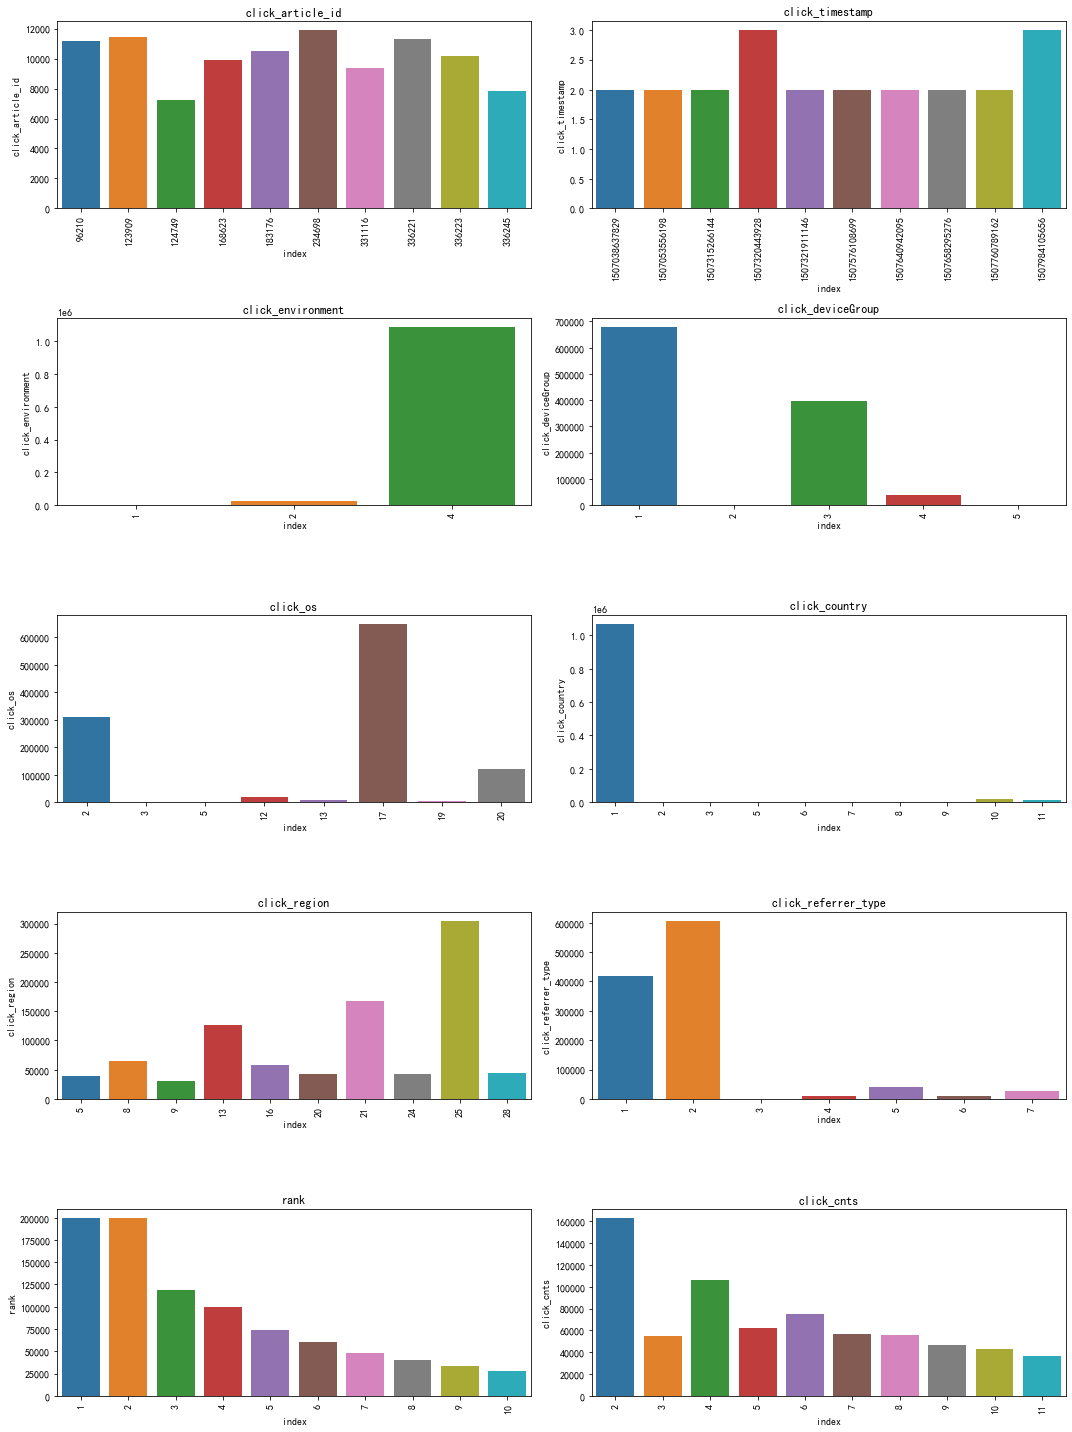

In [10]:
plt.figure()
plt.figure(figsize=(15, 20))
i = 1
for col in ['click_article_id', 'click_timestamp', 'click_environment', 'click_deviceGroup', 'click_os', 'click_country', 
            'click_region', 'click_referrer_type', 'rank', 'click_cnts']:
    plot_envs = plt.subplot(5, 2, i)
    i += 1
    v = trn_click[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [11]:
tst_click = tst_click.merge(item_df, how='left', on=['click_article_id'])
tst_click.head()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
0,249999,160974,1506959142820,4,1,17,1,13,2,19,19,281,1506912747000,259
1,249999,160417,1506959172820,4,1,17,1,13,2,18,19,281,1506942089000,173
2,249998,160974,1506959056066,4,1,12,1,13,2,5,5,281,1506912747000,259
3,249998,202557,1506959086066,4,1,12,1,13,2,4,5,327,1506938401000,219
4,249997,183665,1506959088613,4,1,17,1,15,5,7,7,301,1500895686000,256


In [12]:
tst_click.describe()

,user_id,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,rank,click_cnts,category_id,created_at_ts,words_count
count,518010.000000,518010.000000,5.180100e+05,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,518010.000000,5.180100e+05,518010.000000
mean,227342.428169,193803.792550,1.507387e+12,3.947300,1.738285,13.628467,1.348209,18.250250,1.819614,15.521785,30.043586,305.324961,1.506883e+12,210.966331
std,14613.907188,88279.388177,3.706127e+08,0.323916,1.020858,6.625564,1.703524,7.060798,1.082657,33.957702,56.868021,110.411513,5.816668e+09,83.040065
min,200000.000000,137.000000,1.506959e+12,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.265812e+12,0.000000
25%,214926.000000,128551.000000,1.507026e+12,4.000000,1.000000,12.000000,1.000000,13.000000,1.000000,4.000000,10.000000,252.000000,1.506970e+12,176.000000
50%,229109.000000,199197.000000,1.507308e+12,4.000000,1.000000,17.000000,1.000000,21.000000,2.000000,8.000000,19.000000,323.000000,1.507249e+12,199.000000
75%,240182.000000,272143.000000,1.507666e+12,4.000000,3.000000,17.000000,1.000000,25.000000,2.000000,18.000000,35.000000,399.000000,1.507630e+12,232.000000
max,249999.000000,364043.000000,1.508832e+12,4.000000,5.000000,20.000000,11.000000,28.000000,7.000000,938.000000,938.000000,460.000000,1.509949e+12,3082.000000


In [13]:
#测试集中的用户数量为5w
tst_click.user_id.nunique()

50000

In [14]:
tst_click.groupby('user_id')['click_article_id'].count().min() # 注意测试集里面有只点击过一次文章的用户

1

In [15]:
#新闻文章数据集浏览
item_df.head().append(item_df.tail())

,click_article_id,category_id,created_at_ts,words_count
0,0,0,1513144419000,168
1,1,1,1405341936000,189
2,2,1,1408667706000,250
3,3,1,1408468313000,230
4,4,1,1407071171000,162
364042,364042,460,1434034118000,144
364043,364043,460,1434148472000,463
364044,364044,460,1457974279000,177
364045,364045,460,1515964737000,126
364046,364046,460,1505811330000,479


In [16]:
item_df['words_count'].value_counts()

176     3485
182     3480
179     3463
178     3458
174     3456
183     3432
184     3427
173     3414
180     3403
177     3391
170     3387
187     3355
169     3352
185     3348
175     3346
181     3330
186     3328
189     3327
171     3327
172     3322
165     3308
188     3288
167     3269
190     3261
192     3257
168     3248
193     3225
166     3199
191     3182
194     3164
        ... 
601        1
857        1
1977       1
1626       1
697        1
1720       1
696        1
706        1
592        1
1605       1
586        1
582        1
1606       1
972        1
716        1
584        1
1608       1
715        1
841        1
968        1
964        1
587        1
1099       1
1355       1
711        1
845        1
710        1
965        1
847        1
1535       1
Name: words_count, Length: 866, dtype: int64

461


<AxesSubplot:>

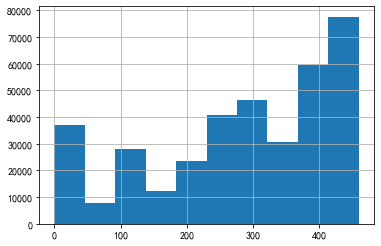

In [17]:
print(item_df['category_id'].nunique())     # 461个文章主题
item_df['category_id'].hist()

In [18]:
item_df.shape       # 364047篇文章

(364047, 4)

In [19]:
item_emb_df.head()

,article_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_240,emb_241,emb_242,emb_243,emb_244,emb_245,emb_246,emb_247,emb_248,emb_249
0,0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [20]:
item_emb_df.shape

(364047, 251)

In [21]:
#####merge
user_click_merge = trn_click.append(tst_click)
#用户重复点击
user_click_count = user_click_merge.groupby(['user_id', 'click_article_id'])['click_timestamp'].agg({'count'}).reset_index()
user_click_count[:10]

,user_id,click_article_id,count
0,0,30760,1
1,0,157507,1
2,1,63746,1
3,1,289197,1
4,2,36162,1
5,2,168401,1
6,3,36162,1
7,3,50644,1
8,4,39894,1
9,4,42567,1


In [22]:
user_click_count[user_click_count['count']>7]

,user_id,click_article_id,count
311242,86295,74254,10
311243,86295,76268,10
393761,103237,205948,10
393763,103237,235689,10
576902,134850,69463,13


In [23]:
def plot_envs(df, cols, r, c):
    plt.figure()
    plt.figure(figsize=(10, 5))
    i = 1
    for col in cols:
        plt.subplot(r, c, i)
        i += 1
        v = df[col].value_counts().reset_index()
        fig = sns.barplot(x=v['index'], y=v[col])
        for item in fig.get_xticklabels():
            item.set_rotation(90)
        plt.title(col)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

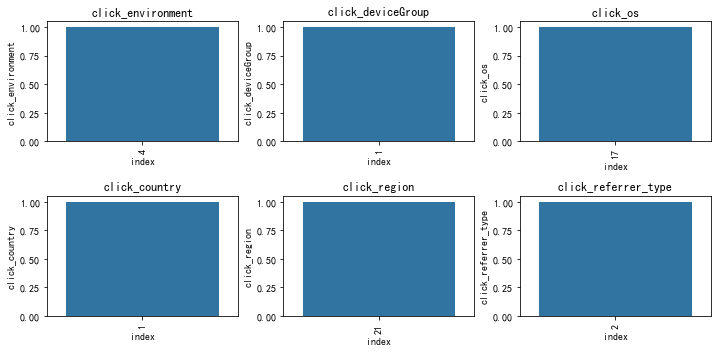

<Figure size 432x288 with 0 Axes>

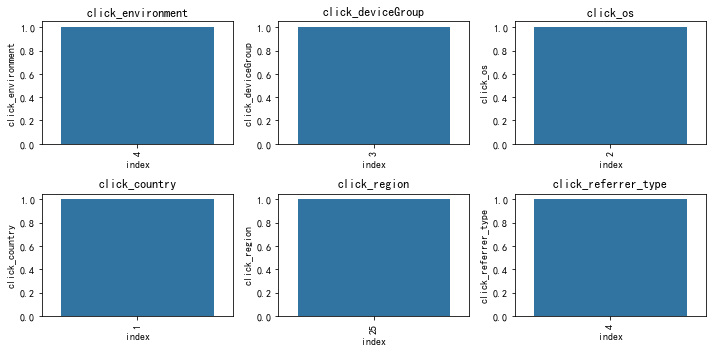

<Figure size 432x288 with 0 Axes>

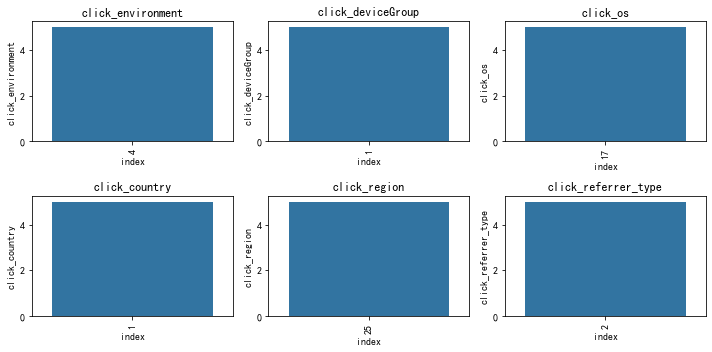

<Figure size 432x288 with 0 Axes>

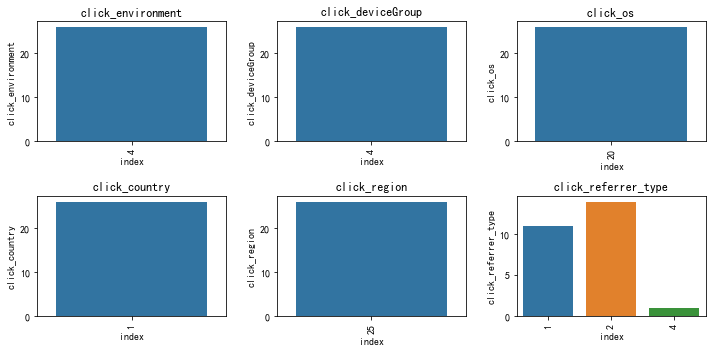

<Figure size 432x288 with 0 Axes>

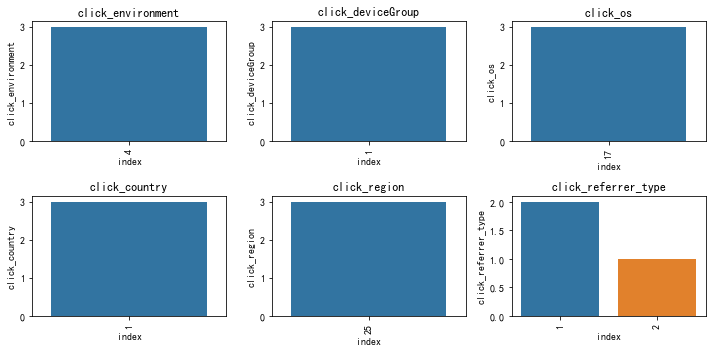

In [24]:
# 分析用户点击环境变化是否明显，这里随机采样10个用户分析这些用户的点击环境分布
sample_user_ids = np.random.choice(tst_click['user_id'].unique(), size=5, replace=False)
sample_users = user_click_merge[user_click_merge['user_id'].isin(sample_user_ids)]
cols = ['click_environment','click_deviceGroup', 'click_os', 'click_country', 'click_region','click_referrer_type']
for _, user_df in sample_users.groupby('user_id'):
    plot_envs(user_df, cols, 2, 3)

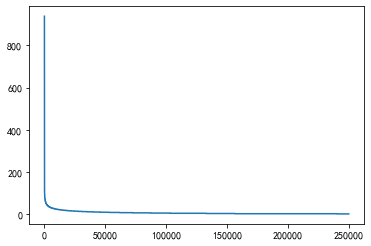

In [25]:
user_click_item_count = sorted(user_click_merge.groupby('user_id')['click_article_id'].count(), reverse=True)
plt.plot(user_click_item_count)

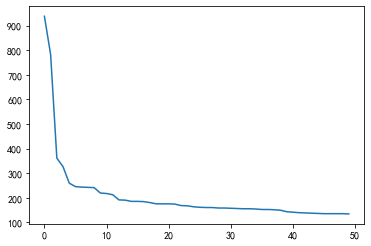

In [26]:
#点击次数在前50的用户
plt.plot(user_click_item_count[:50])

In [30]:
item_click_count = sorted(user_click_merge.groupby('click_article_id')['user_id'].count(), reverse=True)

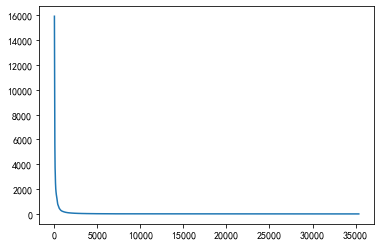

In [31]:
plt.plot(item_click_count)

In [32]:
tmp = user_click_merge.sort_values('click_timestamp')
tmp['next_item'] = tmp.groupby(['user_id'])['click_article_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['click_article_id','next_item'])['click_timestamp'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,433597.000000
mean,3.184139
std,18.851753
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2202.000000


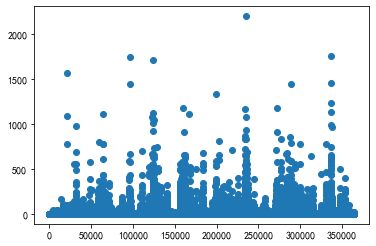

In [33]:
#画个图直观地看一看
x = union_item['click_article_id']
y = union_item['count']
plt.scatter(x, y)

In [34]:
#新闻字数的描述性统计
user_click_merge['words_count'].describe()

count    1.630633e+06
mean     2.043012e+02
std      6.382198e+01
min      0.000000e+00
25%      1.720000e+02
50%      1.970000e+02
75%      2.290000e+02
max      6.690000e+03
Name: words_count, dtype: float64

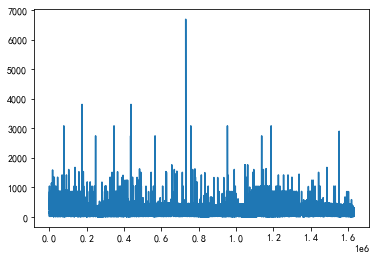

In [35]:
plt.plot(user_click_merge['words_count'].values)

In [36]:
user_click_merge.groupby('user_id')['category_id'].nunique().reset_index().describe()

,user_id,category_id
count,250000.000000,250000.000000
mean,124999.500000,4.573188
std,72168.927986,4.419800
min,0.000000,1.000000
25%,62499.750000,2.000000
50%,124999.500000,3.000000
75%,187499.250000,6.000000
max,249999.000000,95.000000


In [38]:
# 更加详细的参数
user_click_merge.groupby('user_id')['words_count'].mean().reset_index().describe()

,user_id,words_count
count,250000.000000,250000.000000
mean,124999.500000,205.830189
std,72168.927986,47.174030
min,0.000000,8.000000
25%,62499.750000,187.500000
50%,124999.500000,202.000000
75%,187499.250000,217.750000
max,249999.000000,3434.500000


In [1]:
#为了更好的可视化，这里把时间进行归一化操作
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
user_click_merge['click_timestamp'] = mm.fit_transform(user_click_merge[['click_timestamp']])
user_click_merge['created_at_ts'] = mm.fit_transform(user_click_merge[['created_at_ts']])

user_click_merge = user_click_merge.sort_values('click_timestamp')

NameError: name 'user_click_merge' is not defined